# NLP. Определение жанра фильма по его текстовому описанию

Набор данных [Genre Classification Dataset IMDb](https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb)

Основное внимание уделено работе с TensorFlow dataset API.

In [53]:
from pathlib import Path
import tensorflow as tf

DATASET_PATH = Path('./dataset/Genre_Classification_Dataset_IMDb/')

## 1 Подготовка данных. Создание dataset

In [54]:
# Создание набора данных TF

# Создание текстового dataset считывает указанный файл
dataset = tf.data.TextLineDataset([DATASET_PATH/"train_data.txt"])

# Разделение записей (строка) на элементы по разделителю
dataset = dataset.map(lambda x: tf.strings.split(x, ' ::: '))

# Разделение на отдельных "записей" - изменение размерности (4, ) -> (4, 1)
dataset = dataset.map(lambda x: tf.stack(tf.split(x, num_or_size_splits=4)))

# фильтр полей - остаются только жанр и описание
# можно построить словарь и в дальнейшем обращаться к нужной части
dataset = dataset.map(lambda x: {'label': x[2][0], 'text': x[3][0]})

In [55]:
# Создание словаря \ таблицы для кодирования классов
# Для этого используется статический "словарь" - таблица.
init = tf.lookup.KeyValueTensorInitializer(
    keys=tf.constant([b'drama', b'thriller', b'adult', b'documentary', b'comedy',
                      b'crime', b'reality-tv', b'horror', b'sport', b'animation',
                      b'action', b'fantasy', b'short', b'sci-fi', b'music', b'adventure',
                      b'talk-show', b'western', b'family', b'mystery', b'history',
                      b'news', b'biography', b'romance', b'game-show', b'musical', b'war']),
    values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, ], dtype=tf.int64))

table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets=5)

# Заменяем жанры на цифры - применяем полученную таблицу к жанрам.
# Сейчас записи сохранены в виде словаря
dataset = dataset.map(lambda d: (d['text'], table[d['label']]))

In [56]:
# Подготовленный набор данных. Пример записи
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


## 2 Кодирование данных для обучения модели

Векторизация описания фильма:
* Создаётся словарь заданной длины.
* Каждому слову присваивается номер.
* Слова в описании заменяются номерами.
* Если длина описания фильма больше указанной, то описание обрезается.
* Если меньше то дополняется нулями.

In [57]:
# Словарь 150k (всего около 168k), максимальная длина описания 128 (средняя длина около 110 слов)
max_features = 150_000
MAX_SEQUENCE_LENGTH = 128

# Слой препроцесинга. Инициализация
int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Оставляем только описание фильма (без меток жанров)
train_text = dataset.map(lambda f, l: f)

# "обучение" препроцессинга для кодирования
int_vectorize_layer.adapt(train_text)

In [58]:
# Применение кодирования
for i in train_text.take(1):
    print('Текстовое описание:')
    print(i)
    print('Кодирование:')
    print(int_vectorize_layer(i))
    print('Декодирование первого слова:')
    print(int_vectorize_layer.get_vocabulary()[5222])

Текстовое описание:
tf.Tensor(b'Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.', shape=(), dtype=string)
Кодирование:
tf.Tensor(
[ 5222     7     6     4  1979    97     9   520     3   208  8951  2996
   425    56  2254    27     2  1411     6   446    32    12    61    27
     4   291  1138     6   129  4384    12   912     6  1423     6   838
  1867 44256  1397     2   776     7  5051    12   187    15     2   554
  8715    16   831  2786  1397   849    11 10660   576    16     4   713
  9349 

In [59]:
# Кодируем тренировочный dataset (текст)
def int_vectorize_text(*ds):
  return int_vectorize_layer(ds[0]), ds[1]

train_ds = dataset.map(int_vectorize_text)

## 3 Балансировка классов: dataset.rejection_resample
* Жанры не сбалансированы в наборе данных.
* Для их балансировки можно использовать `rejection_resample()`
* Будет стремится соблюсти указанные пропорции между классами

### Расчёт весов для балансировки
* можно не делать `initial_dist` - не обязательный параметр, если не указывать, то пропорция будет строится по факту подачи данных на обучение.
* также можно подавать данные веса в `.fit()` напрямую не балансирую классы через `dataset`.

In [60]:
# расчёт весов для классов
from sklearn.utils import class_weight
import numpy as np

labels = []

for i in train_ds:
  labels.append(i[1].numpy())

labels_unique = list(set(labels))

cw = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = labels_unique, 
                y = np.array(labels))

cw

array([ 0.14750062,  1.26205275,  3.40326428,  0.1533236 ,  0.26962883,
        3.97609094,  2.27140942,  0.91103717,  4.64797668,  4.03197977,
        1.52693987,  6.21648893,  0.39580641,  3.10344038,  2.74682069,
        2.59087216,  5.13536042,  1.94566466,  2.56113001,  6.29443864,
        8.26306965, 11.0935134 ,  7.57707897,  2.98798501, 10.35013364,
        7.24883006, 15.21156004])

In [61]:
# Функция возвращает класс для балансировки
def class_func(features, label):
  return label


# Балансировка набора данных
dataset_resampler = train_ds.rejection_resample(
    class_func   = class_func, 
    target_dist  = [0.037,0.037,0.037,0.037,0.037,
                    0.037,0.037,0.037,0.037,0.037,
                    0.037,0.037,0.037,0.037,0.037,
                    0.037,0.037,0.037,0.037,0.037,
                    0.037,0.037,0.037,0.037,0.037,
                    0.037,0.038,],
    initial_dist = cw) # None

# При балансировке добавляются классы получается лишниее поле, его нужно убрать
train_ds_balanced = dataset_resampler.map(lambda extra_label, features_and_label: features_and_label)

# После балансировки получается - 4310 при None - автоматическое определение весов классов, 33_186 - если использовать веса

len(list(train_ds_balanced))

33186

## 4 Разделение набора данных на тренировочный и валидационный

In [62]:
AUTOTUNE = tf.data.AUTOTUNE

# Тренировочный набор 85%
train = train_ds_balanced.take(28200)
train = train.cache().prefetch(buffer_size=AUTOTUNE).batch(128, drop_remainder=True)

# Валидационный 15%
val = train_ds_balanced.skip(28200)
val = val.cache().prefetch(buffer_size=AUTOTUNE).batch(128, drop_remainder=True)

## 5 Архитектура сети и обучение модели

In [63]:
embedding_dim = 64
H_SIZE = 64
CLASS_AMOUNT = 27

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(H_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    ),
     tf.keras.layers.Bidirectional(
         tf.keras.layers.LSTM(H_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)
    ),
    tf.keras.layers.Dense(CLASS_AMOUNT, activation=tf.nn.softmax),
])

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',
    name='sparse_categorical_crossentropy')

metric = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)

model.compile(optimizer='adam', loss=loss, metrics=[metric])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          9600064   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 27)                3483      
                                                                 
Total params: 9,768,411
Trainable params: 9,768,411
Non-trainable params: 0
_________________________________________________________________


In [64]:
NUM_EPOCHS = 15

history = model.fit(train,
                    validation_data=val,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    )

Epoch 1/15
220/220 [==============================] - 252s 1s/step - loss: 1.4297 - sparse_categorical_accuracy: 0.4118 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.5820
Epoch 2/15
220/220 [==============================] - 204s 928ms/step - loss: 0.9710 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.9172 - val_sparse_categorical_accuracy: 0.7235
Epoch 3/15
220/220 [==============================] - 203s 921ms/step - loss: 0.7748 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9404 - val_sparse_categorical_accuracy: 0.7284
Epoch 4/15
220/220 [==============================] - 201s 914ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.8300 - val_loss: 1.0173 - val_sparse_categorical_accuracy: 0.7239
Epoch 5/15
220/220 [==============================] - 201s 915ms/step - loss: 0.4506 - sparse_categorical_accuracy: 0.8773 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.7190
Epoch 6/15
220/220 [==============================] - 202s 920ms/step - loss: 0.369

## 6 Визуализация обучения

In [65]:
from matplotlib import pyplot as plt

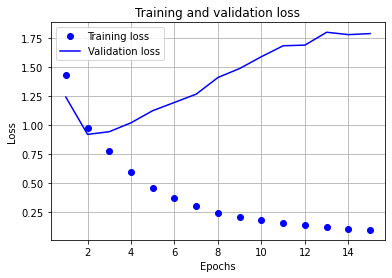

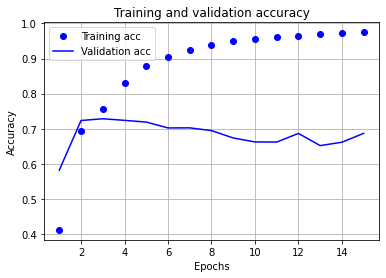

In [66]:
epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## 6 Сохранение модели

In [67]:
tf.keras.models.save_model(model=model, 
                           filepath='./model', 
                           save_format='tf', 
                           include_optimizer=True, )

import shutil
shutil.make_archive('model', 'zip', './model')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


'/content/model.zip'

## 7 Проверка по тестовому набору данных

In [68]:
dataset_test = tf.data.TextLineDataset([DATASET_PATH / "test_data_solution.txt"])

dataset_test = dataset_test.map(lambda x: tf.strings.split(x, ' ::: '))
dataset_test = dataset_test.map(lambda x: tf.stack(tf.split(x, num_or_size_splits=4)))
dataset_test = dataset_test.map(lambda t: {'label': t[2][0], 'text': t[3][0]})

dataset_test = dataset_test.map(lambda ds: (ds['text'], table[ds['label']]))

dataset_test = dataset_test.map(int_vectorize_text)

test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE).batch(128, drop_remainder=True)

In [69]:
results = model.evaluate(test)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

423/423 [==============================] - 81s 192ms/step - loss: 3.7071 - sparse_categorical_accuracy: 0.4580
Test loss: 3.7071
Test accuracy: 45.80 %
